# 2a) Frozen weights

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LSTM, Embedding
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam

In [ ]:
# store csv contents in dataframe
file_path = "/content/Tweets.csv"

df = pd.read_csv(file_path)

In [ ]:
# remove all other columns
df = df[['text', 'airline_sentiment']].dropna()

In [ ]:
max_length = 30
epochs = 100

In [ ]:
# categorical labels converted to integer labels
# neutral, positive, negative => 0 and 1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])

# converts labels into vectors
y = to_categorical(y)

In [ ]:
tokenizer = Tokenizer(oov_token=1)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# add padding (zeroes) at the end
X = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
# embedding dimension = 100 dimensional
embeddings_index = dict()
f = open('/content/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# Because we're using GloVE, need to create a word embedding/word context matrix
# Create a matrix of weights for words in the training set
# One embedding for each word in the training set

# Get all unique words in our training set: Tokenizer index
# Find the corresponding weight vector in GloVe embedding

# Define size of embedding matrix: number of unique words x embedding dim (100)
embedding_matrix = np.zeros((vocab_size, 100))
t = Tokenizer()
t.fit_on_texts(df['text'])
# fill in matrix
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                            input_length = max_length, trainable=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
#split into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#split training data into train and validtion data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [ ]:
#early stopping
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')> 0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
frozen_model = Sequential()
frozen_model.add(embedding_layer)
frozen_model.add(LSTM(32, activation='tanh', return_sequences=True))
frozen_model.add(LSTM(32, activation='tanh', return_sequences=False))
frozen_model.add(Dense(256, activation='relu'))
frozen_model.add(Dense(3, activation='softmax'))
frozen_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
frozen_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       1,577,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,577,000 (6.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,577,000 (6.02 MB)

In [ ]:
frozen_history = frozen_model.fit(X_train, Y_train, epochs=epochs, verbose=1, validation_data=(X_val, Y_val), callbacks=[callbacks])

Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6239 - loss: 0.8739 - val_accuracy: 0.6556 - val_loss: 0.8119
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6706 - loss: 0.7813 - val_accuracy: 0.6859 - val_loss: 0.7622
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7090 - loss: 0.7180 - val_accuracy: 0.6948 - val_loss: 0.7413
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7280 - loss: 0.6778 - val_accuracy: 0.7021 - val_loss: 0.7182
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7380 - loss: 0.6530 - val_accuracy: 0.7106 - val_loss: 0.7115
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7640 - loss: 0.6067 - val_accuracy: 0.7204 - val_loss: 0.6854
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7789 - loss: 0.5641 - val_accuracy: 0.7209 - val_loss: 0.6903
Epoch 8/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7877 - loss: 0.5564 - val_a

In [ ]:
frozen_model.evaluate(X_test, Y_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7014 - loss: 1.2110


[1.2183603048324585, 0.7103825211524963]

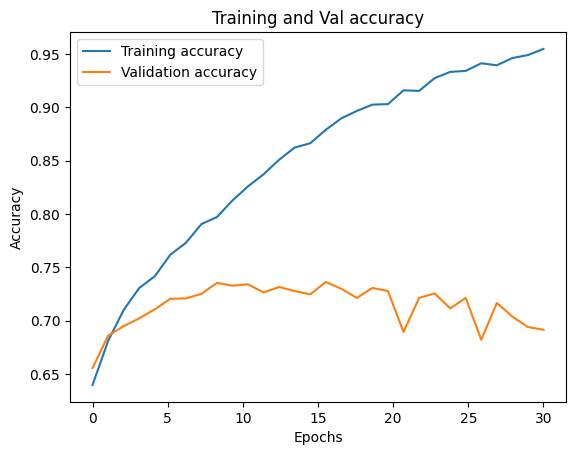

In [ ]:
plt.plot(np.linspace(0, len(frozen_history.history['accuracy']), len(frozen_history.history['accuracy'])), frozen_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(frozen_history.history['val_accuracy']), len(frozen_history.history['val_accuracy'])), frozen_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 2b) Fine-tune weights

In [ ]:
fine_tue_embedding = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                               input_length = max_length, trainable=True)

In [ ]:
fine_tune_model = Sequential()
fine_tune_model.add(embedding_layer)
fine_tune_model.add(LSTM(32, activation='tanh', return_sequences=True))
fine_tune_model.add(LSTM(32, activation='tanh', return_sequences=False))
fine_tune_model.add(Dense(256, activation='relu'))
fine_tune_model.add(Dense(3, activation='softmax'))
fine_tune_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
fine_tune_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 30, 100)             │       1,577,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,577,000 (6.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,577,000 (6.02 MB)

In [ ]:
fine_tune_history = fine_tune_model.fit(X_train, Y_train, epochs=epochs, verbose=1, validation_data=(X_val, Y_val), callbacks=[callbacks])

Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6338 - loss: 0.8641 - val_accuracy: 0.6325 - val_loss: 0.8371
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6782 - loss: 0.7882 - val_accuracy: 0.6842 - val_loss: 0.7651
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7079 - loss: 0.7244 - val_accuracy: 0.6991 - val_loss: 0.7296
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7250 - loss: 0.6790 - val_accuracy: 0.7106 - val_loss: 0.7173
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7361 - loss: 0.6607 - val_accuracy: 0.7196 - val_loss: 0.6891
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7550 - loss: 0.6260 - val_accuracy: 0.7204 - val_loss: 0.6952
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7663 - loss: 0.5877 - val_accuracy: 0.7273 - val_loss: 0.7070
Epoch 8/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7791 - loss: 0.5459 - val_acc

In [ ]:
fine_tune_model.evaluate(X_test, Y_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7308 - loss: 1.1320


[1.0914019346237183, 0.7366803288459778]

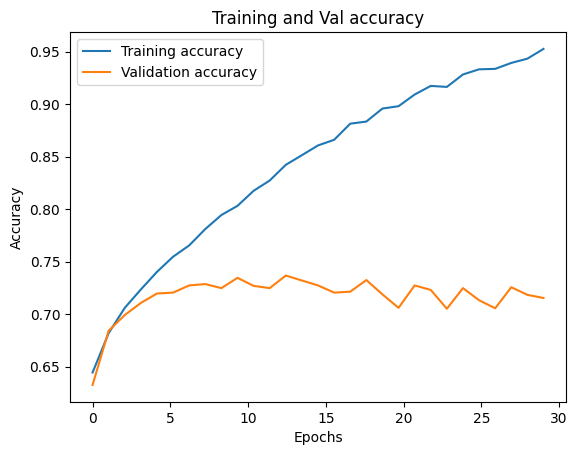

In [ ]:
plt.plot(np.linspace(0, len(fine_tune_history.history['accuracy']), len(fine_tune_history.history['accuracy'])), fine_tune_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(fine_tune_history.history['val_accuracy']), len(fine_tune_history.history['val_accuracy'])), fine_tune_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()